In [20]:
import pandas as pd
import matplotlib 
%matplotlib inline
A = pandas.read_csv("~/Documents/Insight/massdriver/data/CrashDataExport_20160602_1716.csv")

In [22]:
A["Crash Date"] = pd.to_datetime(A["Crash Date"])

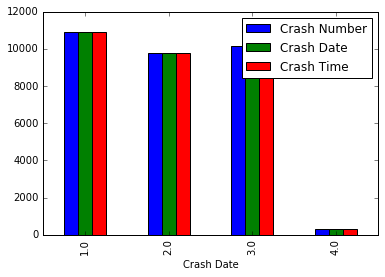

In [23]:
A.groupby(A["Crash Date"].dt.month).count().plot(kind="bar")